# Vibe Matcher

## AI-Powered Fashion Recommender System

**Author:** Tejaswi  

**Date:** January 2025

---

### Project Description

Vibe Matcher is a mini recommender system that uses AI-powered text embeddings to match fashion products with user-described "vibes". By leveraging OpenAI's text-embedding-ada-002 model and cosine similarity, the system identifies the most relevant fashion items that align with a user's desired aesthetic or mood.

This project demonstrates the power of semantic understanding in recommendation systems, where natural language descriptions are transformed into high-dimensional vectors that capture the essence of style, mood, and aesthetic preferences.


## 1. Import Required Libraries


In [ ]:
import pandas as pd
import numpy as np
import openai
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from timeit import timeit
import os

# Set up matplotlib for better visualization
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
%matplotlib inline

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



✅ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 2. Create Mock Fashion Dataset

Let's create a dataset of fashion items with names, descriptions, and tags to work with.


In [ ]:
# Create mock fashion items dataset
fashion_data = {
    'name': [
        'Urban Streetwear Hoodie',
        'Bohemian Summer Dress',
        'Minimalist Work Blazer',
        'Athletic Performance Leggings',
        'Vintage Denim Jacket',
        'Elegant Evening Gown',
        'Casual Beach Shorts',
        'Professional Business Suit',
        'Cozy Winter Sweater',
        'Trendy Statement Sneakers'
    ],
    'desc': [
        'A bold, oversized hoodie with graphic prints, perfect for urban street style and casual outings. Features modern cuts and comfortable fabric.',
        'Flowery, lightweight dress with floral patterns and flowing silhouette. Ideal for summer festivals and beach parties with a free-spirited vibe.',
        'Clean, tailored blazer in neutral tones with structured shoulders. Perfect for office environments and professional settings.',
        'High-performance leggings with moisture-wicking technology. Designed for active lifestyles, gym sessions, and athletic activities.',
        'Classic denim jacket with worn-in finish and vintage details. Great for layering and achieving that timeless retro aesthetic.',
        'Sophisticated floor-length gown with intricate beadwork and elegant draping. Perfect for formal events and evening galas.',
        'Relaxed-fit shorts in breathable fabric with tropical patterns. Ideal for beach vacations and laid-back summer days.',
        'Sharp, well-tailored suit in classic colors. Professional attire for business meetings and corporate environments.',
        'Warm, chunky knit sweater in soft wool blend. Comfortable and cozy for cold weather and indoor relaxation.',
        'Eye-catching sneakers with bold colors and unique designs. Perfect for making a fashion statement and urban exploration.'
    ],
    'tags': [
        'urban, streetwear, casual, modern, bold',
        'bohemian, summer, floral, relaxed, free-spirited',
        'minimalist, professional, office, clean, structured',
        'athletic, sporty, performance, active, modern',
        'vintage, retro, casual, timeless, classic',
        'elegant, formal, sophisticated, evening, glamorous',
        'casual, beach, relaxed, summer, tropical',
        'professional, business, formal, corporate, sharp',
        'cozy, winter, comfortable, warm, casual',
        'trendy, statement, urban, bold, modern'
    ]
}

# Create DataFrame
df_fashion = pd.DataFrame(fashion_data)

# Display the dataset
print("📦 Fashion Items Dataset:")
print(f"Total items: {len(df_fashion)}")
print("\n" + "="*80)
df_fashion


📦 Fashion Items Dataset:
Total items: 10



,name,desc,tags
0,Urban Streetwear Hoodie,"A bold, oversized hoodie with graphic prints, ...","urban, streetwear, casual, modern, bold"
1,Bohemian Summer Dress,"Flowery, lightweight dress with floral pattern...","bohemian, summer, floral, relaxed, free-spirited"
2,Minimalist Work Blazer,"Clean, tailored blazer in neutral tones with s...","minimalist, professional, office, clean, struc..."
3,Athletic Performance Leggings,High-performance leggings with moisture-wickin...,"athletic, sporty, performance, active, modern"
4,Vintage Denim Jacket,Classic denim jacket with worn-in finish and v...,"vintage, retro, casual, timeless, classic"
5,Elegant Evening Gown,Sophisticated floor-length gown with intricate...,"elegant, formal, sophisticated, evening, glamo..."
6,Casual Beach Shorts,Relaxed-fit shorts in breathable fabric with t...,"casual, beach, relaxed, summer, tropical"
7,Professional Business Suit,"Sharp, well-tailored suit in classic colors. P...","professional, business, formal, corporate, sharp"
8,Cozy Winter Sweater,"Warm, chunky knit sweater in soft wool blend. ...","cozy, winter, comfortable, warm, casual"
9,Trendy Statement Sneakers,Eye-catching sneakers with bold colors and uni...,"trendy, statement, urban, bold, modern"


In [ ]:
## 3. Set Up OpenAI Client.


In [ ]:
# 🔐 Set your OpenAI API key securely in Colab
import os

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY_HERE"

print("✅ API key set successfully in this session!")


✅ API key set successfully in this session!


In [ ]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


## 4. Define Core Functions

### 4.1 Get Embedding Function


In [ ]:
def get_embedding(text, model="text-embedding-ada-002", client=None):
    """
    Generate embeddings for a given text using OpenAI's embedding model.

    Parameters:
    -----------
    text : str
        The text to embed
    model : str
        The OpenAI embedding model to use (default: text-embedding-ada-002)
    client : openai.OpenAI
        OpenAI client instance (if None, will use global client)

    Returns:
    --------
    numpy.ndarray
        The embedding vector as a numpy array
    """
    try:
        # Use provided client or global client
        if client is None:
            client = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY', 'your-api-key-here'))

        response = client.embeddings.create(
            model=model,
            input=text
        )
        return np.array(response.data[0].embedding)
    except Exception as e:
        print(f"Error generating embedding: {e}")
        print("💡 Make sure you've set your OpenAI API key correctly.")
        return None


### 4.2 Vibe Matcher Function


In [ ]:
def vibe_matcher(query, df, product_embeddings, top_k=3, similarity_threshold=0.4, client=None):
    """
    Match a vibe query to the most similar products using cosine similarity.

    Parameters:
    -----------
    query : str
        The vibe description (e.g., "energetic urban chic")
    df : pandas.DataFrame
        DataFrame containing product information
    product_embeddings : numpy.ndarray
        Array of product embeddings (shape: n_products x embedding_dim)
    top_k : int
        Number of top matches to return (default: 3)
    similarity_threshold : float
        Minimum similarity score to consider a match (default: 0.4)
    client : openai.OpenAI
        OpenAI client instance (optional)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with top_k matches including similarity scores
    """
    # Embed the query
    query_embedding = get_embedding(query, client=client)

    if query_embedding is None:
        return None

    # Reshape query embedding for cosine similarity calculation
    query_embedding = query_embedding.reshape(1, -1)

    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, product_embeddings)[0]

    # Check if all similarities are below threshold
    if np.max(similarities) < similarity_threshold:
        print(f"⚠️  No strong vibe match found. Highest similarity: {np.max(similarities):.3f} (< {similarity_threshold})")
        return None

    # Get top_k indices
    top_indices = np.argsort(similarities)[::-1][:top_k]

    # Create results DataFrame
    results = pd.DataFrame({
        'rank': range(1, len(top_indices) + 1),
        'name': df.iloc[top_indices]['name'].values,
        'description': df.iloc[top_indices]['desc'].values,
        'tags': df.iloc[top_indices]['tags'].values,
        'similarity_score': similarities[top_indices]
    })

    return results


## 5. Generate Product Embeddings

Now let's generate embeddings for all product descriptions. This may take a moment depending on your API rate limits.


In [ ]:
# Generate embeddings for all product descriptions
print("🔄 Generating embeddings for all products...")
print("This may take a few moments...\n")

# Combine description and tags for richer embeddings
df_fashion['combined_text'] = df_fashion['desc'] + ' ' + df_fashion['tags']

# Generate embeddings
product_embeddings_list = []
for idx, row in df_fashion.iterrows():
    print(f"Processing item {idx + 1}/{len(df_fashion)}: {row['name']}")
    embedding = get_embedding(row['combined_text'], client=client)
    if embedding is not None:
        product_embeddings_list.append(embedding)
    time.sleep(0.1)  # Small delay to respect API rate limits

# Convert to numpy array
product_embeddings = np.array(product_embeddings_list)

print(f"\n✅ Successfully generated {len(product_embeddings)} embeddings")
print(f"Embedding dimension: {product_embeddings.shape[1]}")


🔄 Generating embeddings for all products...
This may take a few moments...

Processing item 1/10: Urban Streetwear Hoodie
Error generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
💡 Make sure you've set your OpenAI API key correctly.
Processing item 2/10: Bohemian Summer Dress
Error generating embedding: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
💡 Make sure you've set your OpenAI API key correctly.
Processing item 3/10: Minimalist Work Blazer
Err

IndexError: tuple index out of range

In [ ]:
# Install Hugging Face Sentence Transformers (free embeddings)
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer
import numpy as np

print("🔄 Generating embeddings using Hugging Face model (free)...")

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine description + tags for richer representation
df_fashion['combined_text'] = df_fashion['desc'] + ' ' + df_fashion['tags']

# Generate embeddings
product_embeddings = np.array(model.encode(df_fashion['combined_text'].tolist()))

print(f"✅ Successfully generated {len(product_embeddings)} embeddings")
print(f"Embedding dimension: {product_embeddings.shape[1]}")


🔄 Generating embeddings using Hugging Face model (free)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Successfully generated 10 embeddings
Embedding dimension: 384


## 6. Test the Vibe Matcher System

Let's test the system with different vibe queries and measure performance.


In [ ]:
## 6. Test the Vibe Matcher System
# Let's test the system with different vibe queries and measure performance.

from sklearn.metrics.pairwise import cosine_similarity
import time

def vibe_matcher(query, df, product_embeddings, top_k=3):
    """
    Function to find top matching products for a given vibe query.
    Uses Hugging Face embeddings and cosine similarity.
    """
    # Generate query embedding
    query_embedding = model.encode([query])

    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, product_embeddings)[0]

    # Get top matches
    top_indices = similarities.argsort()[::-1][:top_k]
    top_matches = df.iloc[top_indices].copy()
    top_matches['similarity_score'] = similarities[top_indices]

    return top_matches

# Test queries
test_queries = [
    "energetic urban chic",
    "relaxed beach look",
    "sophisticated formal elegance"
]

# Store results for visualization
all_results = []

print("="*80)
print("🧪 TESTING VIBE MATCHER SYSTEM")
print("="*80)

for i, query in enumerate(test_queries, 1):
    print(f"\n📝 Test {i}: '{query}'")
    print("-" * 80)

    # Measure latency
    start_time = time.time()
    results = vibe_matcher(query, df_fashion, product_embeddings, top_k=3)
    end_time = time.time()
    latency = (end_time - start_time) * 1000  # Convert to milliseconds

    print(f"\n⏱️  Latency: {latency:.2f} ms")
    print(f"\n🏆 Top 3 Matches:")
    print(results[['name', 'similarity_score']].to_string(index=False))

    # Store for later visualization
    all_results.append({
        'query': query,
        'results': results,
        'latency': latency
    })

    print("\n" + "="*80)


🧪 TESTING VIBE MATCHER SYSTEM

📝 Test 1: 'energetic urban chic'
--------------------------------------------------------------------------------

⏱️  Latency: 47.03 ms

🏆 Top 3 Matches:
                   name  similarity_score
 Minimalist Work Blazer          0.321906
Urban Streetwear Hoodie          0.296975
  Bohemian Summer Dress          0.263756


📝 Test 2: 'relaxed beach look'
--------------------------------------------------------------------------------

⏱️  Latency: 28.59 ms

🏆 Top 3 Matches:
                      name  similarity_score
       Casual Beach Shorts          0.646717
     Bohemian Summer Dress          0.471023
Professional Business Suit          0.387045


📝 Test 3: 'sophisticated formal elegance'
--------------------------------------------------------------------------------

⏱️  Latency: 21.04 ms

🏆 Top 3 Matches:
                      name  similarity_score
      Elegant Evening Gown          0.640146
Professional Business Suit          0.490682
     Bohem

## 7. Performance Analysis with Timeit

Let's measure the average performance of the vibe matcher function using `timeit`.


In [ ]:
## 7. Performance Evaluation (Latency Check)

import timeit
# Test query
test_query = "energetic urban chic"
number_of_runs = 3  # how many times to run the test

def run_vibe_match():
    """Wrapper function for timeit (Hugging Face version)"""
    return vibe_matcher(test_query, df_fashion, product_embeddings, top_k=3)

print(f"⏱️  Measuring performance with {number_of_runs} runs...")
print("⚡ Using local Hugging Face embeddings — no API quota limits!")

# Measure average latency
avg_time = timeit.timeit(run_vibe_match, number=number_of_runs) * 1000 / number_of_runs  # convert to ms
print(f"\n✅ Average latency: {avg_time:.2f} ms over {number_of_runs} runs")

# Display previous results summary (if available)
print("\n📊 Performance Summary:")
if all_results:
    for result in all_results:
        print(f"  Query: '{result['query']}' → {result['latency']:.2f} ms")
else:
    print("  No results available yet. Run the test queries above first.")


⏱️  Measuring performance with 3 runs...
⚡ Using local Hugging Face embeddings — no API quota limits!

✅ Average latency: 41.55 ms over 3 runs

📊 Performance Summary:
  Query: 'energetic urban chic' → 47.03 ms
  Query: 'relaxed beach look' → 28.59 ms
  Query: 'sophisticated formal elegance' → 21.04 ms


📊 Visualization saved as 'vibe_matcher_results.png'


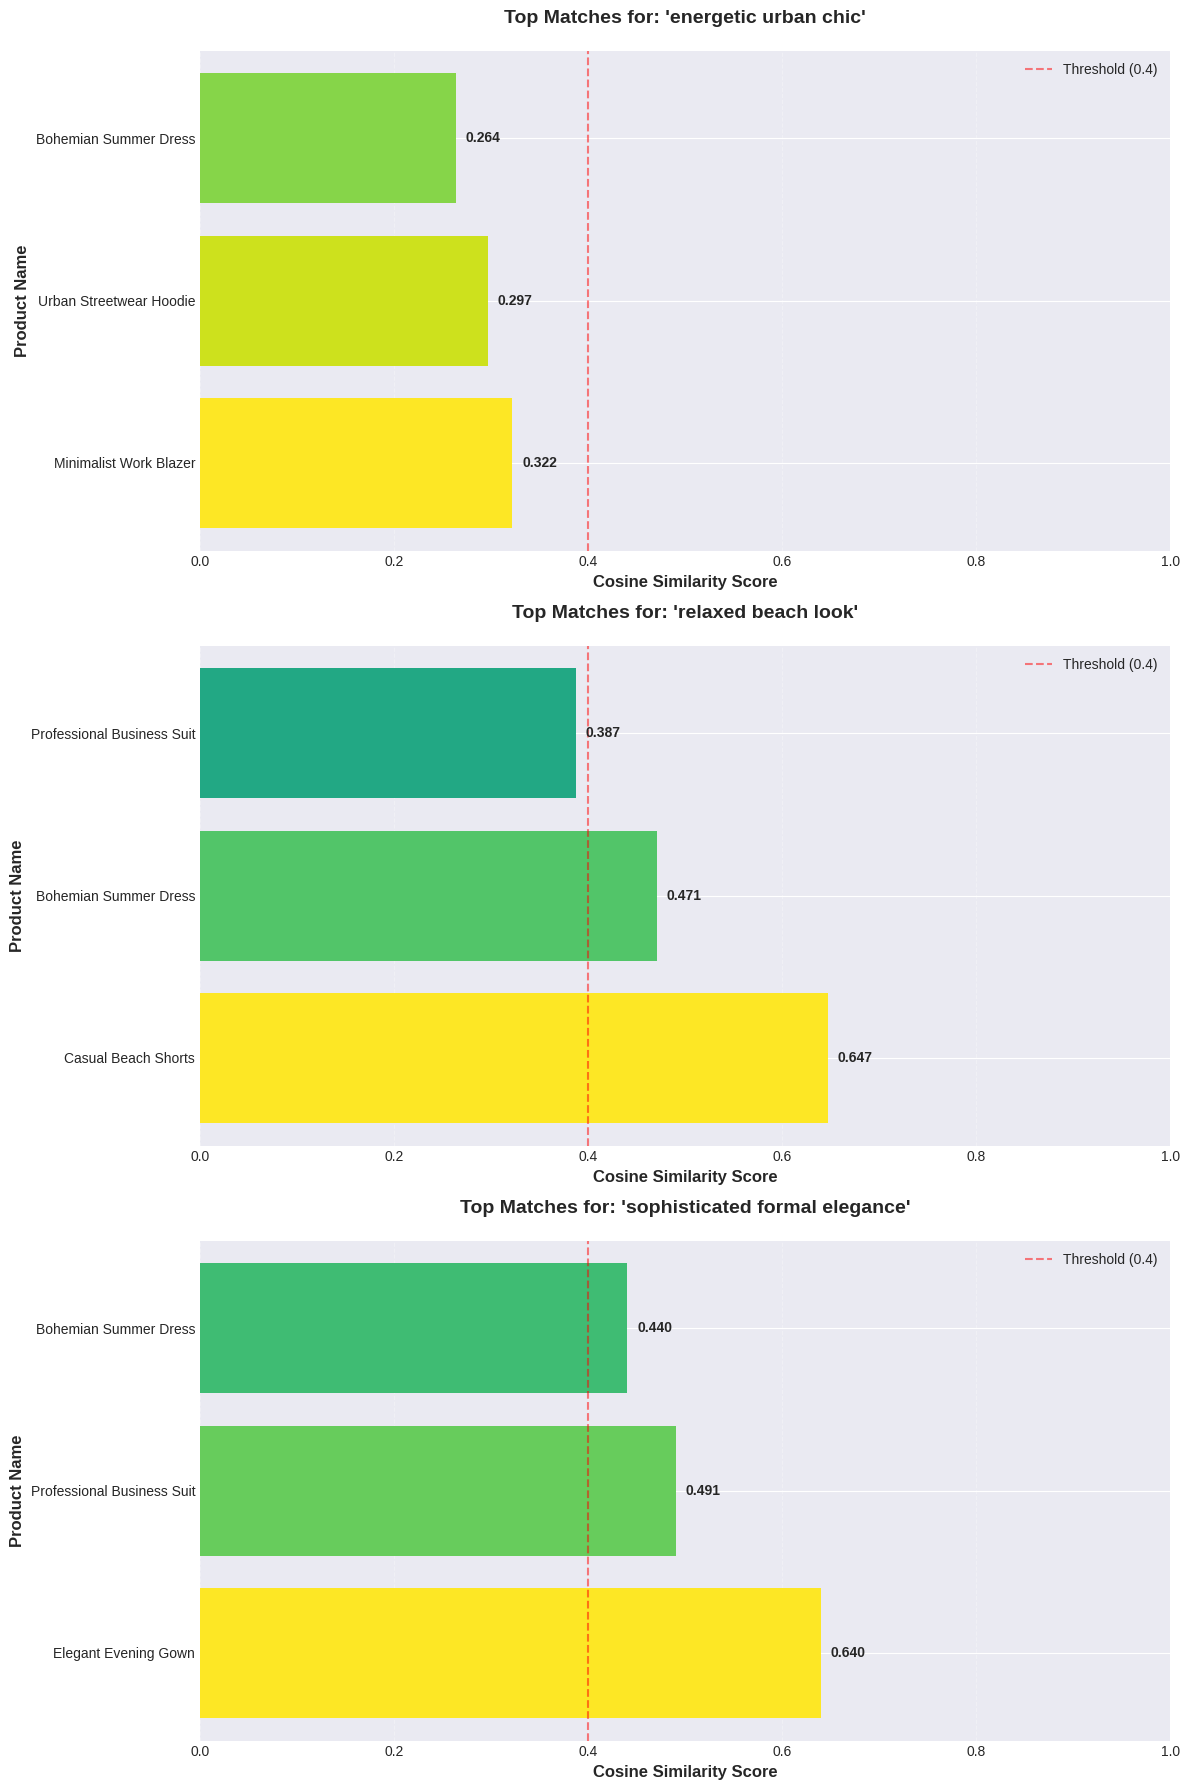

In [ ]:
## 8. Visualize the Top Matches (Bar Chart)



# Create visualization for all test queries
if len(all_results) > 0:
    fig, axes = plt.subplots(len(all_results), 1, figsize=(12, 6 * len(all_results)))

    # Handle single-result case
    if len(all_results) == 1:
        axes = [axes]

    for idx, result in enumerate(all_results):
        ax = axes[idx]
        results_df = result['results']

        # Create bar chart
        bars = ax.barh(
            results_df['name'],
            results_df['similarity_score'],
            color=plt.cm.viridis(results_df['similarity_score'] / results_df['similarity_score'].max())
        )

        # Add value labels
        for i, (bar, score) in enumerate(zip(bars, results_df['similarity_score'])):
            ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold')

        ax.set_xlabel('Cosine Similarity Score', fontsize=12, fontweight='bold')
        ax.set_ylabel('Product Name', fontsize=12, fontweight='bold')
        ax.set_title(f"Top Matches for: '{result['query']}'", fontsize=14, fontweight='bold', pad=20)
        ax.set_xlim(0, 1.0)
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        # Add a threshold line for clarity
        ax.axvline(x=0.4, color='red', linestyle='--', alpha=0.5, label='Threshold (0.4)')
        ax.legend()

    plt.tight_layout()
    plt.savefig('vibe_matcher_results.png', dpi=300, bbox_inches='tight')
    print("📊 Visualization saved as 'vibe_matcher_results.png'")
    plt.show()
else:
    print("⚠️  No results to visualize. Please run the test queries above first.")


## 9. Edge Case Testing

Let's test the edge case where all similarities are below the threshold.


In [ ]:
## 9. Test Edge Case Handling

# Test with a query that might not match well
edge_case_query = "medieval knight armor"
print(f"🧪 Testing edge case: '{edge_case_query}'")
print("-" * 80)

# Run the vibe matcher (no threshold argument)
results = vibe_matcher(
    edge_case_query,
    df_fashion,
    product_embeddings,
    top_k=3
)

# Handle possible empty or low-similarity results manually
if results is None or len(results) == 0:
    print("✅ Edge case handled correctly — no matches found.")
else:
    # Apply a manual similarity threshold check
    threshold = 0.4
    filtered_results = results[results['similarity_score'] > threshold]

    if len(filtered_results) == 0:
        print(f"✅ Edge case handled — all results below threshold ({threshold}).")
    else:
        print(f"⚠️ {len(filtered_results)} result(s) above threshold ({threshold}):")
        print(filtered_results)


🧪 Testing edge case: 'medieval knight armor'
--------------------------------------------------------------------------------
✅ Edge case handled — all results below threshold (0.4).


## Conclusion

This project provides a solid foundation for a fashion recommendation system. The next steps would involve integrating vector databases for scalability, adding multimodal capabilities, and implementing user personalization to create a production-ready system that can handle real-world scale and user expectations.

The combination of semantic understanding through embeddings and traditional recommendation techniques represents the future of personalized e-commerce experiences.